--- GENERATOR WYKRESÓW (Wersja XGBoost + NLP) ---
✅ Połączono z MongoDB.
📊 Dane gotowe: 16381 rekordów.
Generowanie: Feature Importance...
-> Zapisano wykres_1.png
Generowanie: Macierz Korelacji...
-> Zapisano wykres_2.png
Generowanie: Wpływ wyposażenia...


C:\Users\micha\AppData\Local\Temp\ipykernel_24504\3930834874.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_viz, x='is_4x4', y='price', ax=axes[0], palette="Blues", showfliers=False)
C:\Users\micha\AppData\Local\Temp\ipykernel_24504\3930834874.py:121: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Napęd Oś', 'Napęd 4x4'])
C:\Users\micha\AppData\Local\Temp\ipykernel_24504\3930834874.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_viz, x='is_sport_pkg', y='price', ax=axes[1], palette="Reds", showfliers=False)
C:\Users\micha\AppData\Local\Temp\ipykernel_245

-> Zapisano wykres_3.png
Generowanie: Krzywa spadku wartości...
-> Zapisano wykres_4.png
Generowanie: Ranking Marek...


C:\Users\micha\AppData\Local\Temp\ipykernel_24504\3930834874.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top15, x='brand', y='price', order=order, palette="Spectral", showfliers=False)


-> Zapisano wykres_5.png

✅ GOTOWE! Wszystkie wykresy wygenerowane.


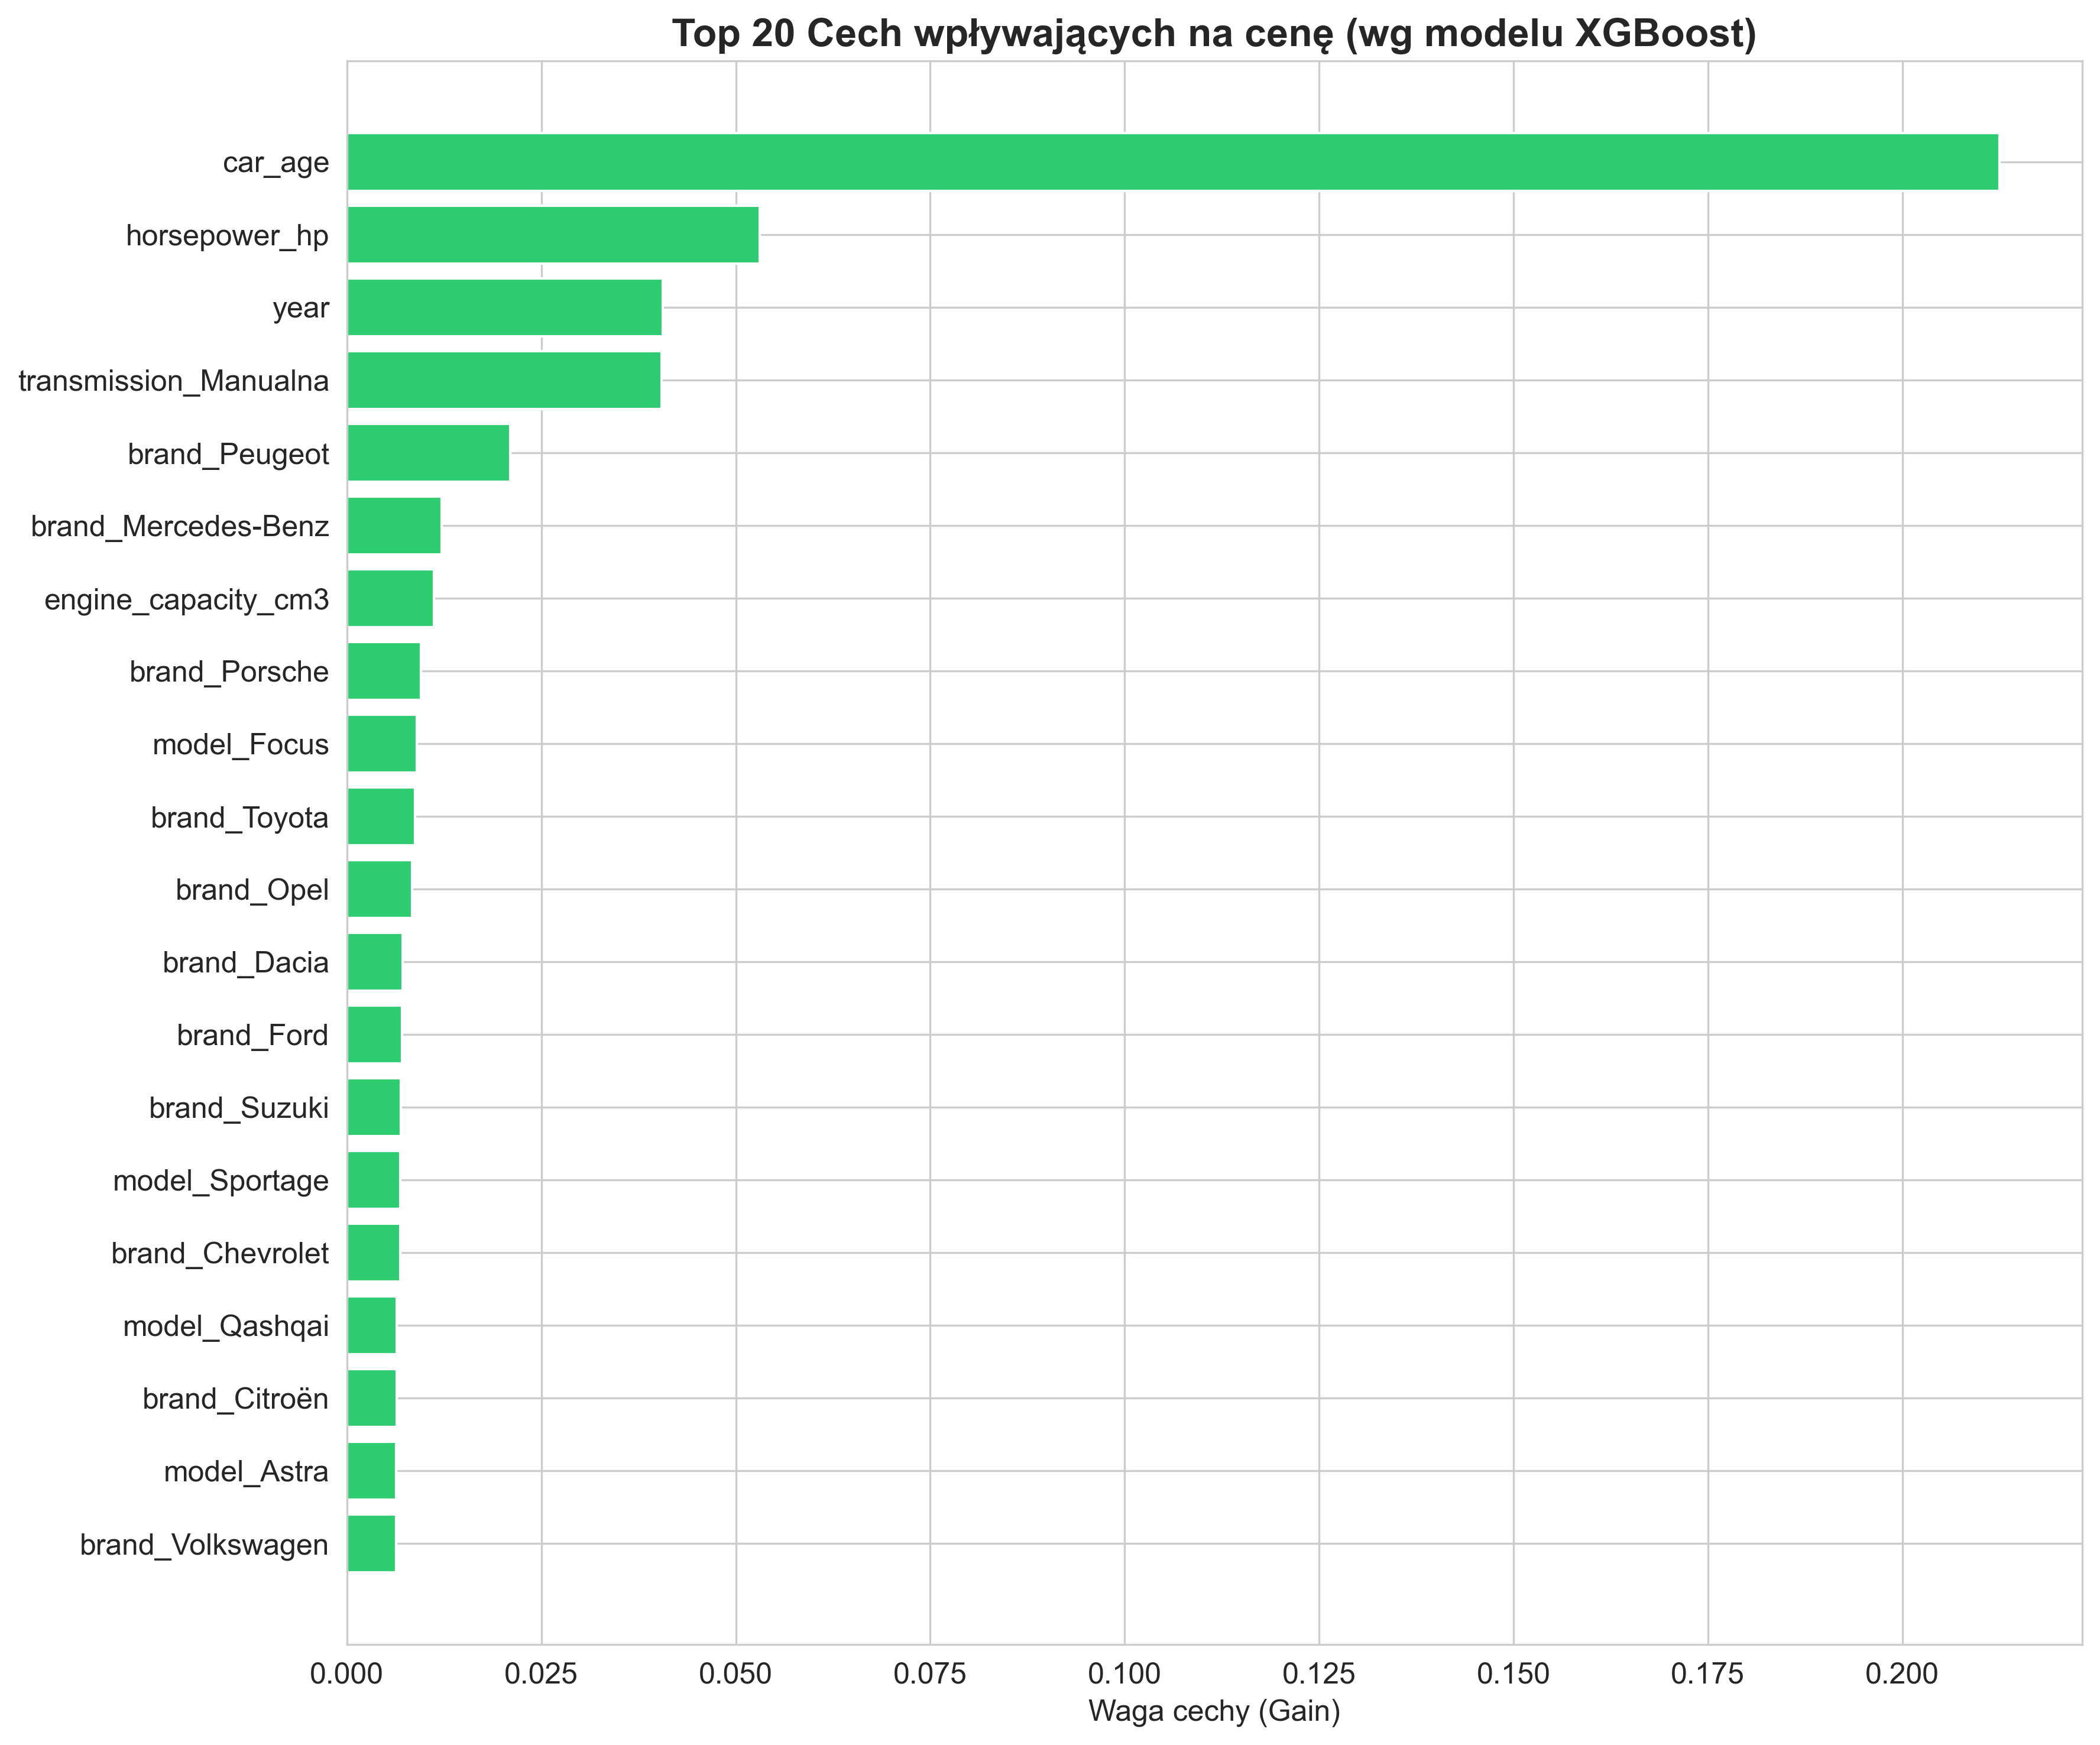

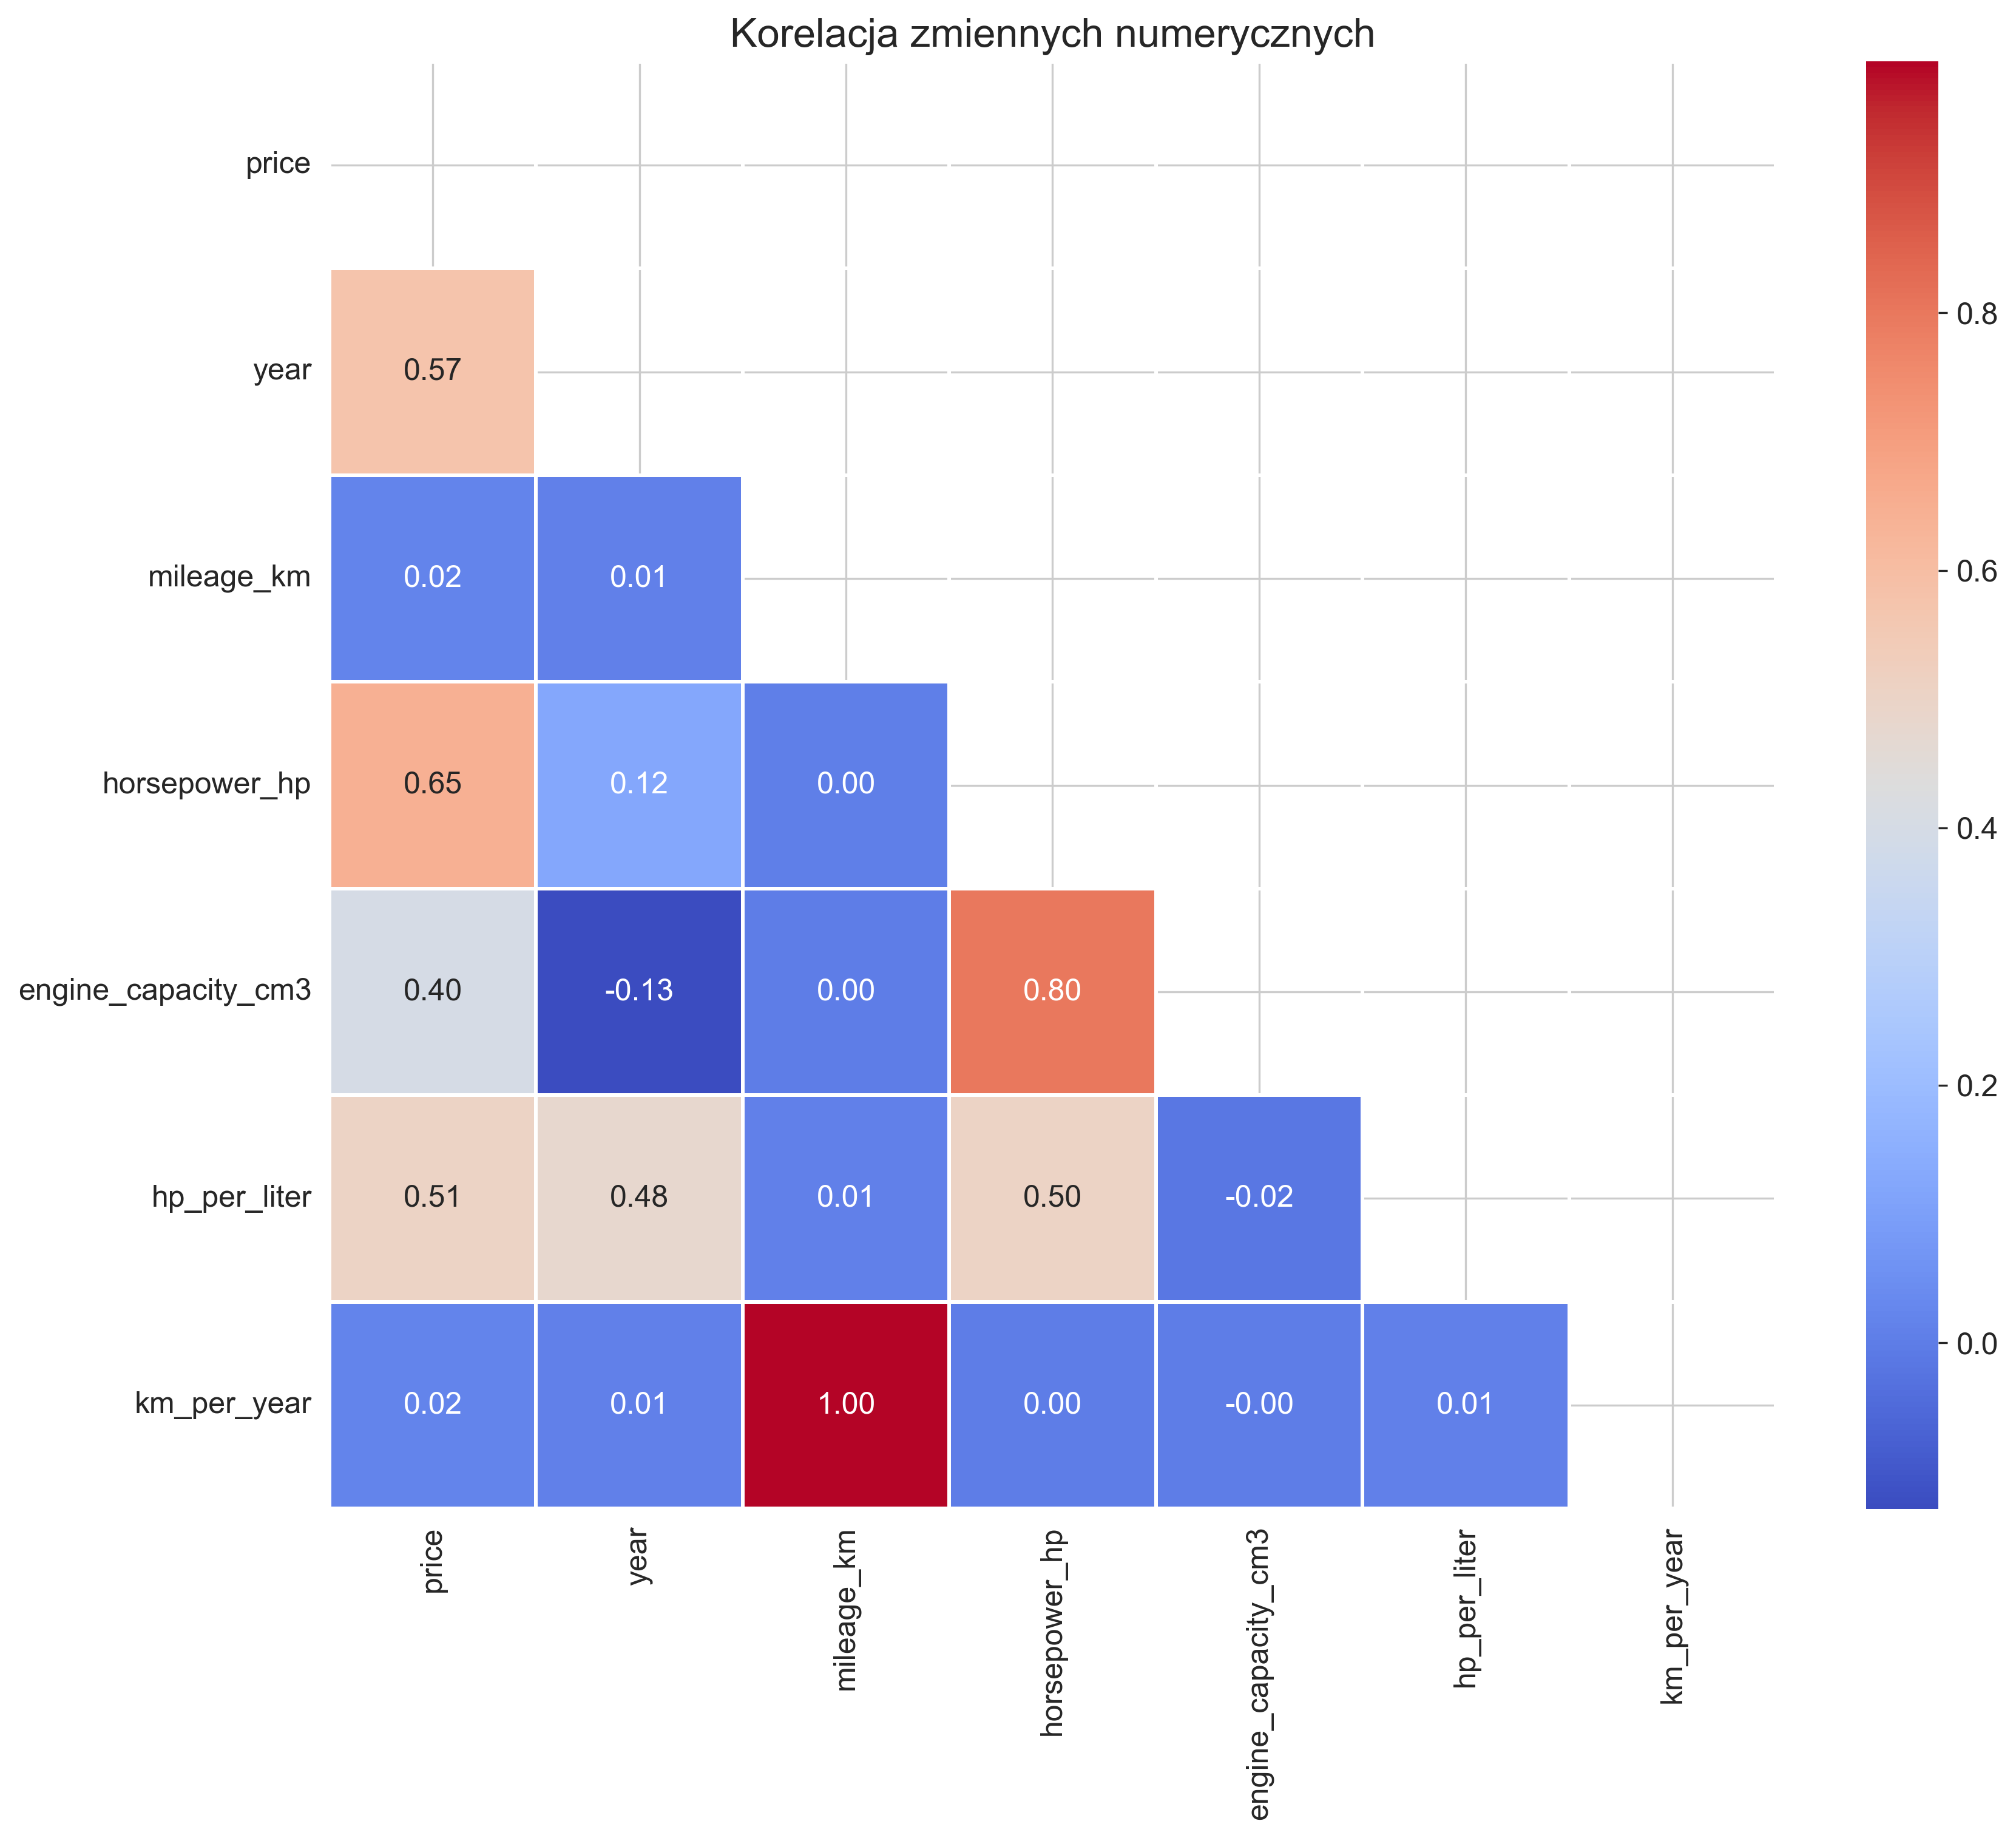

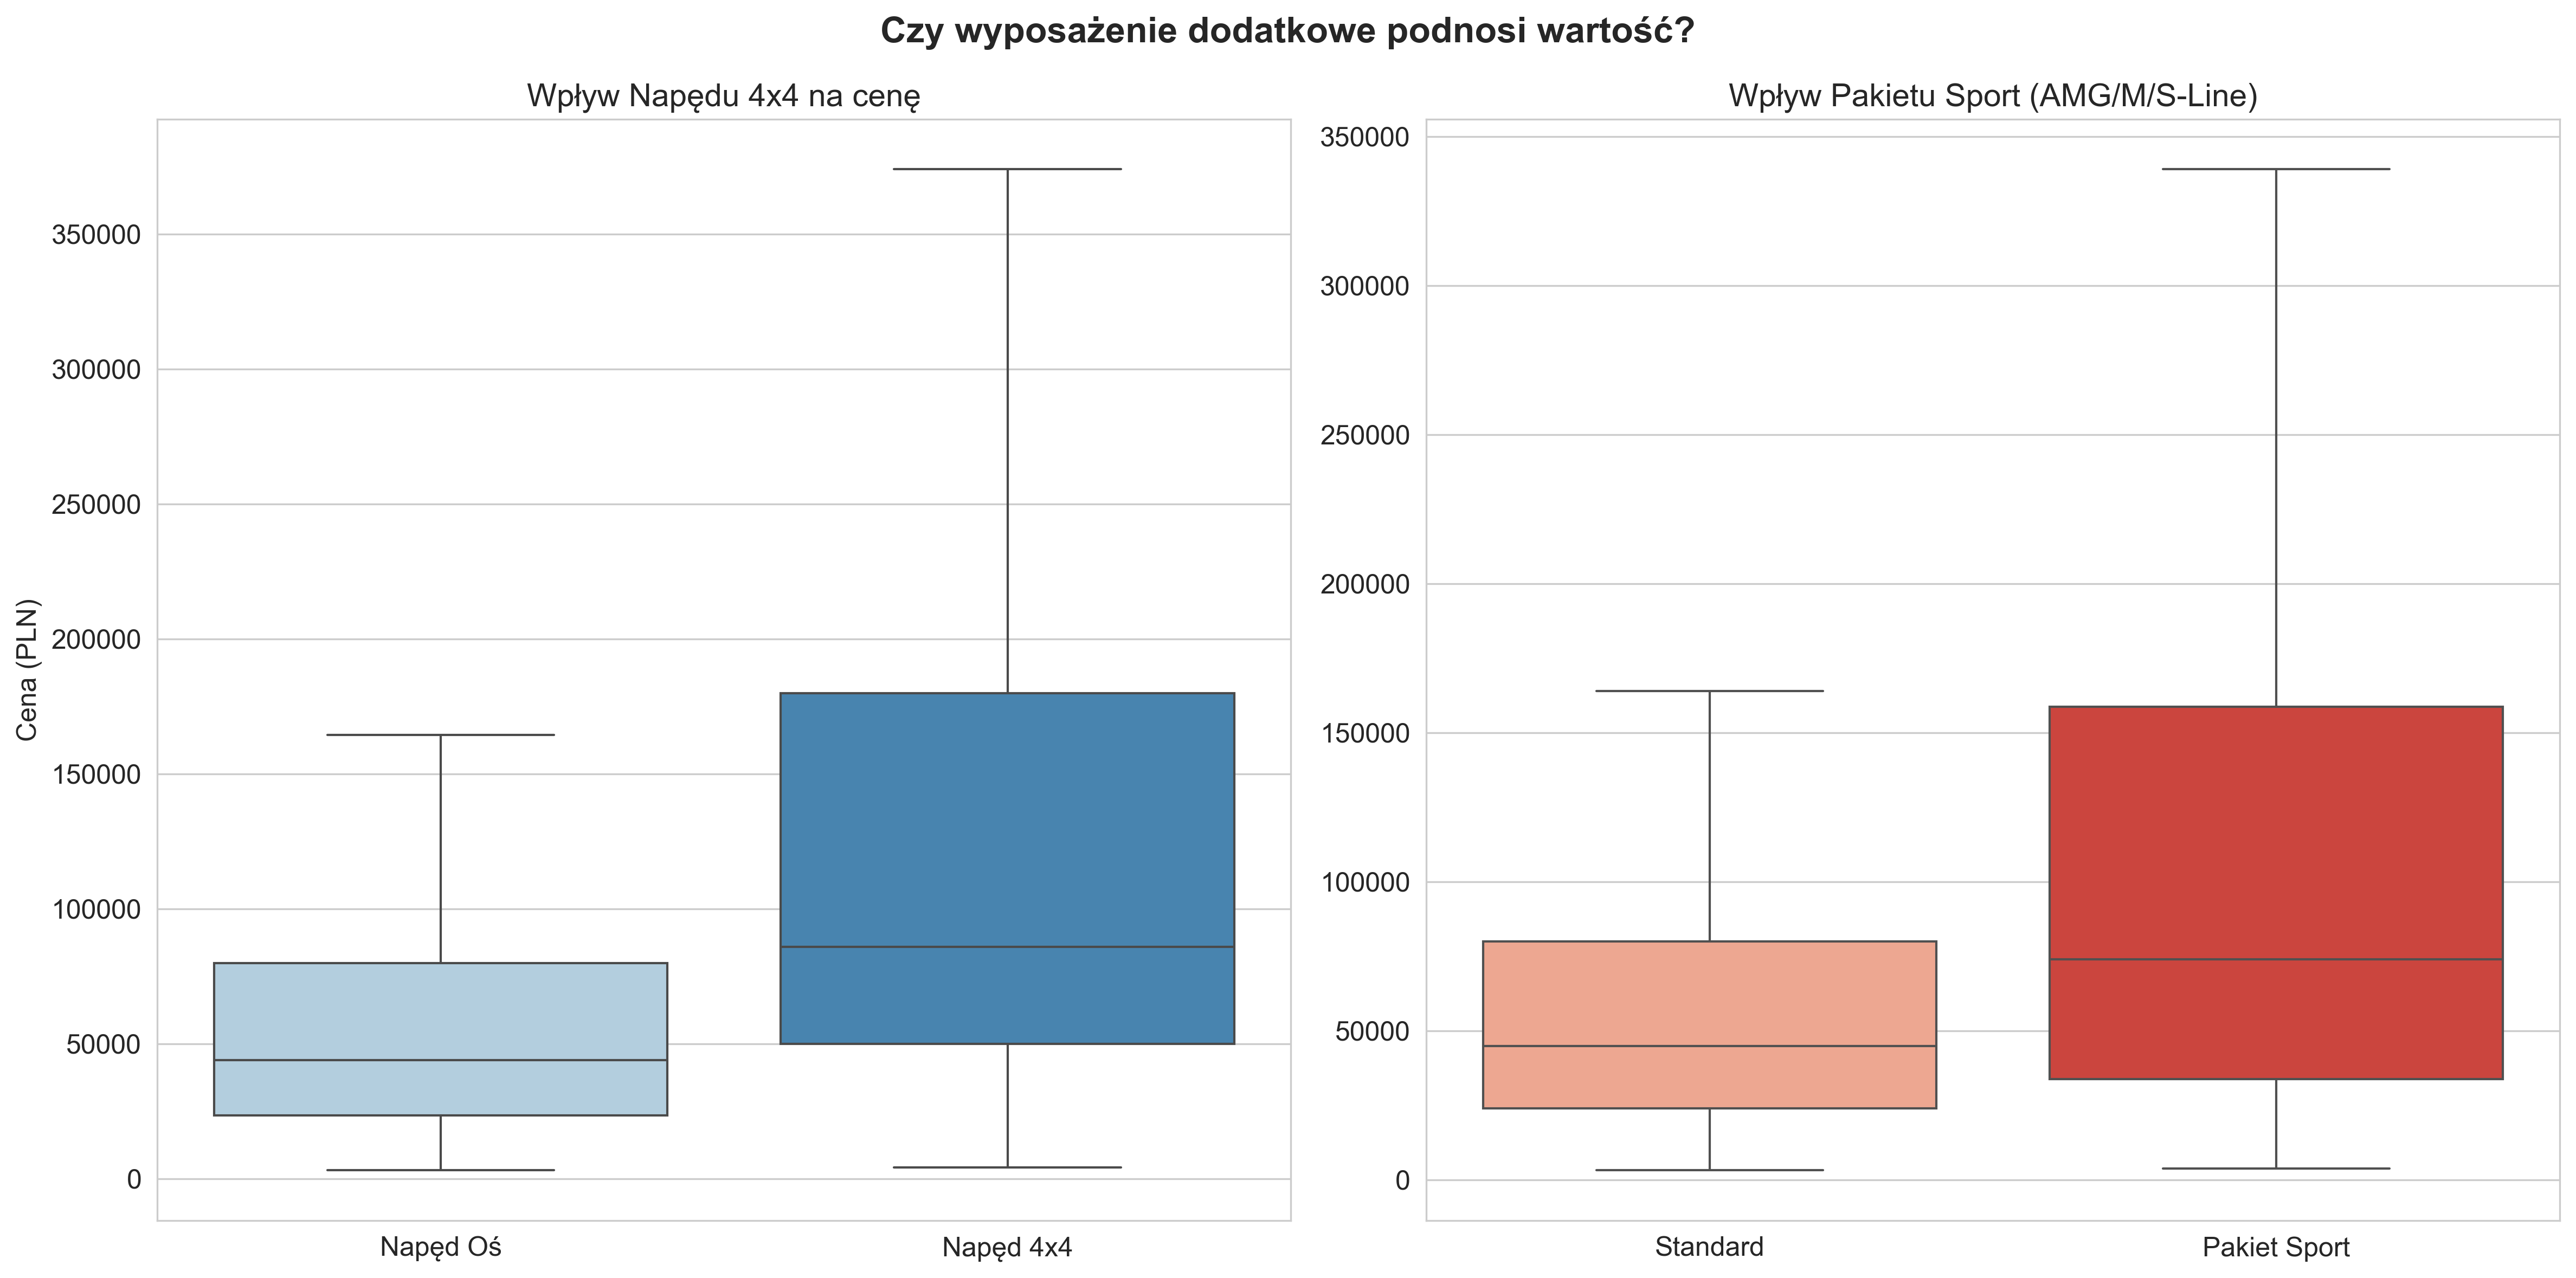

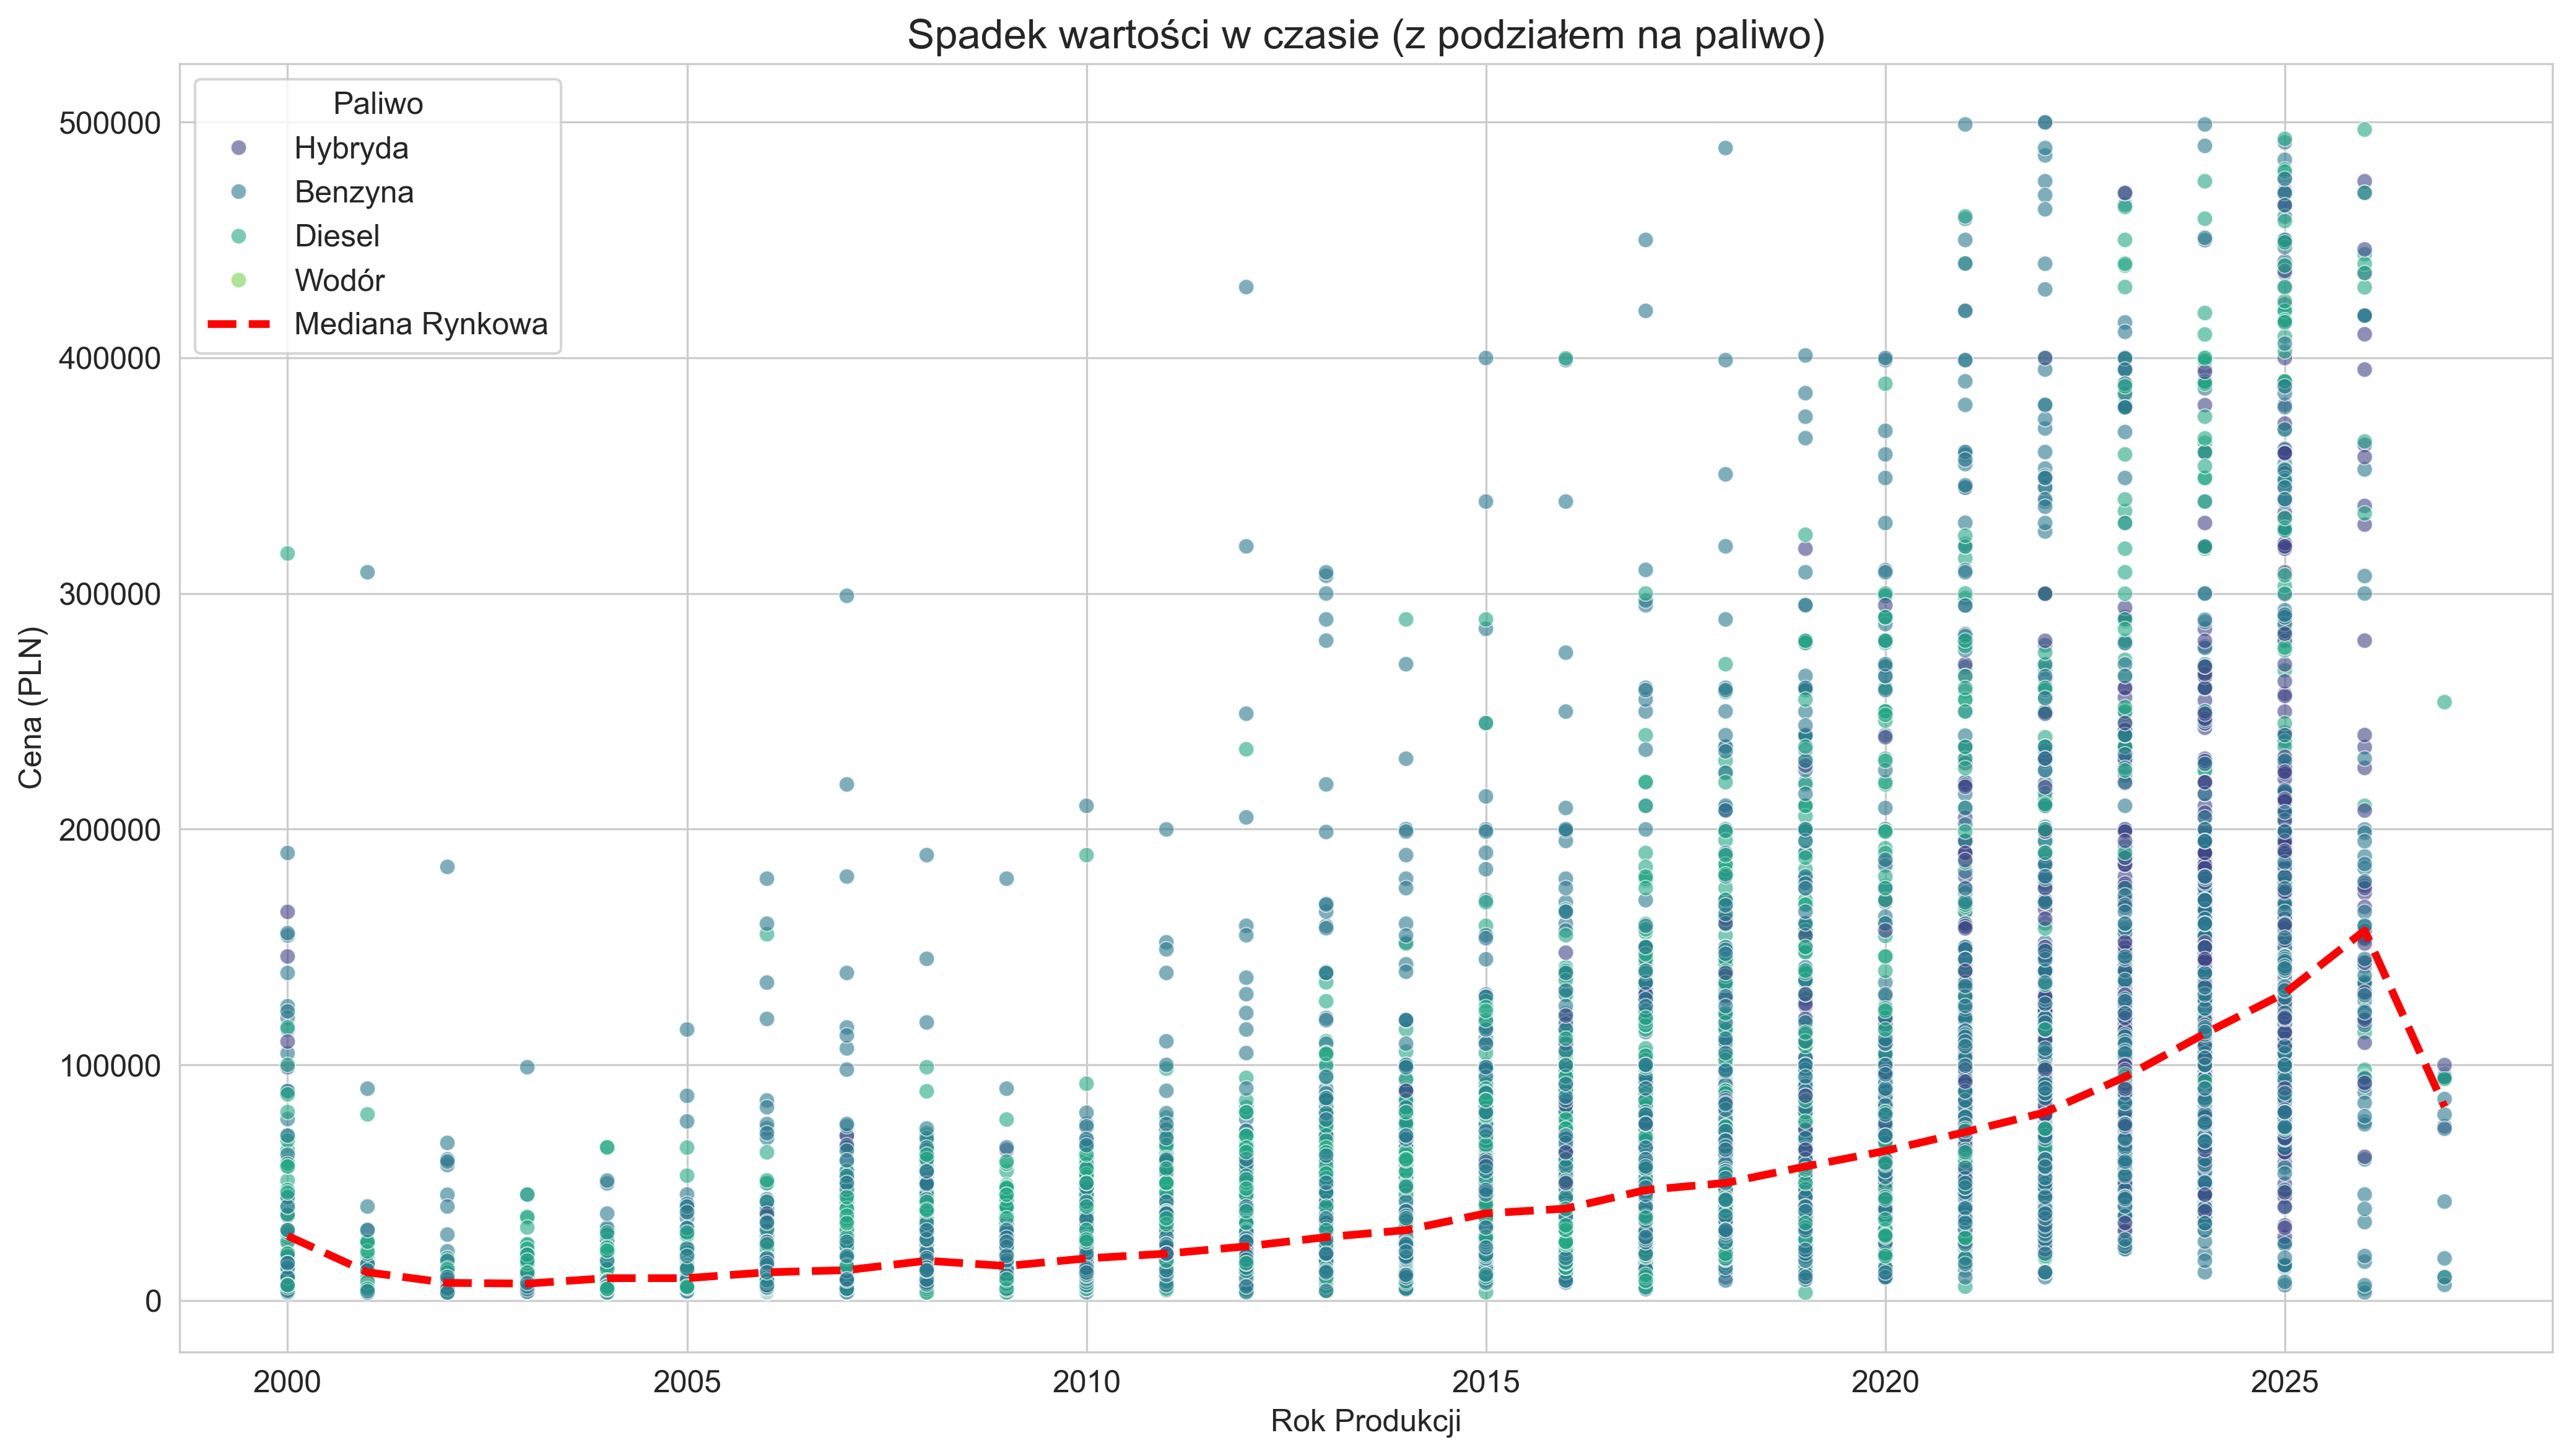

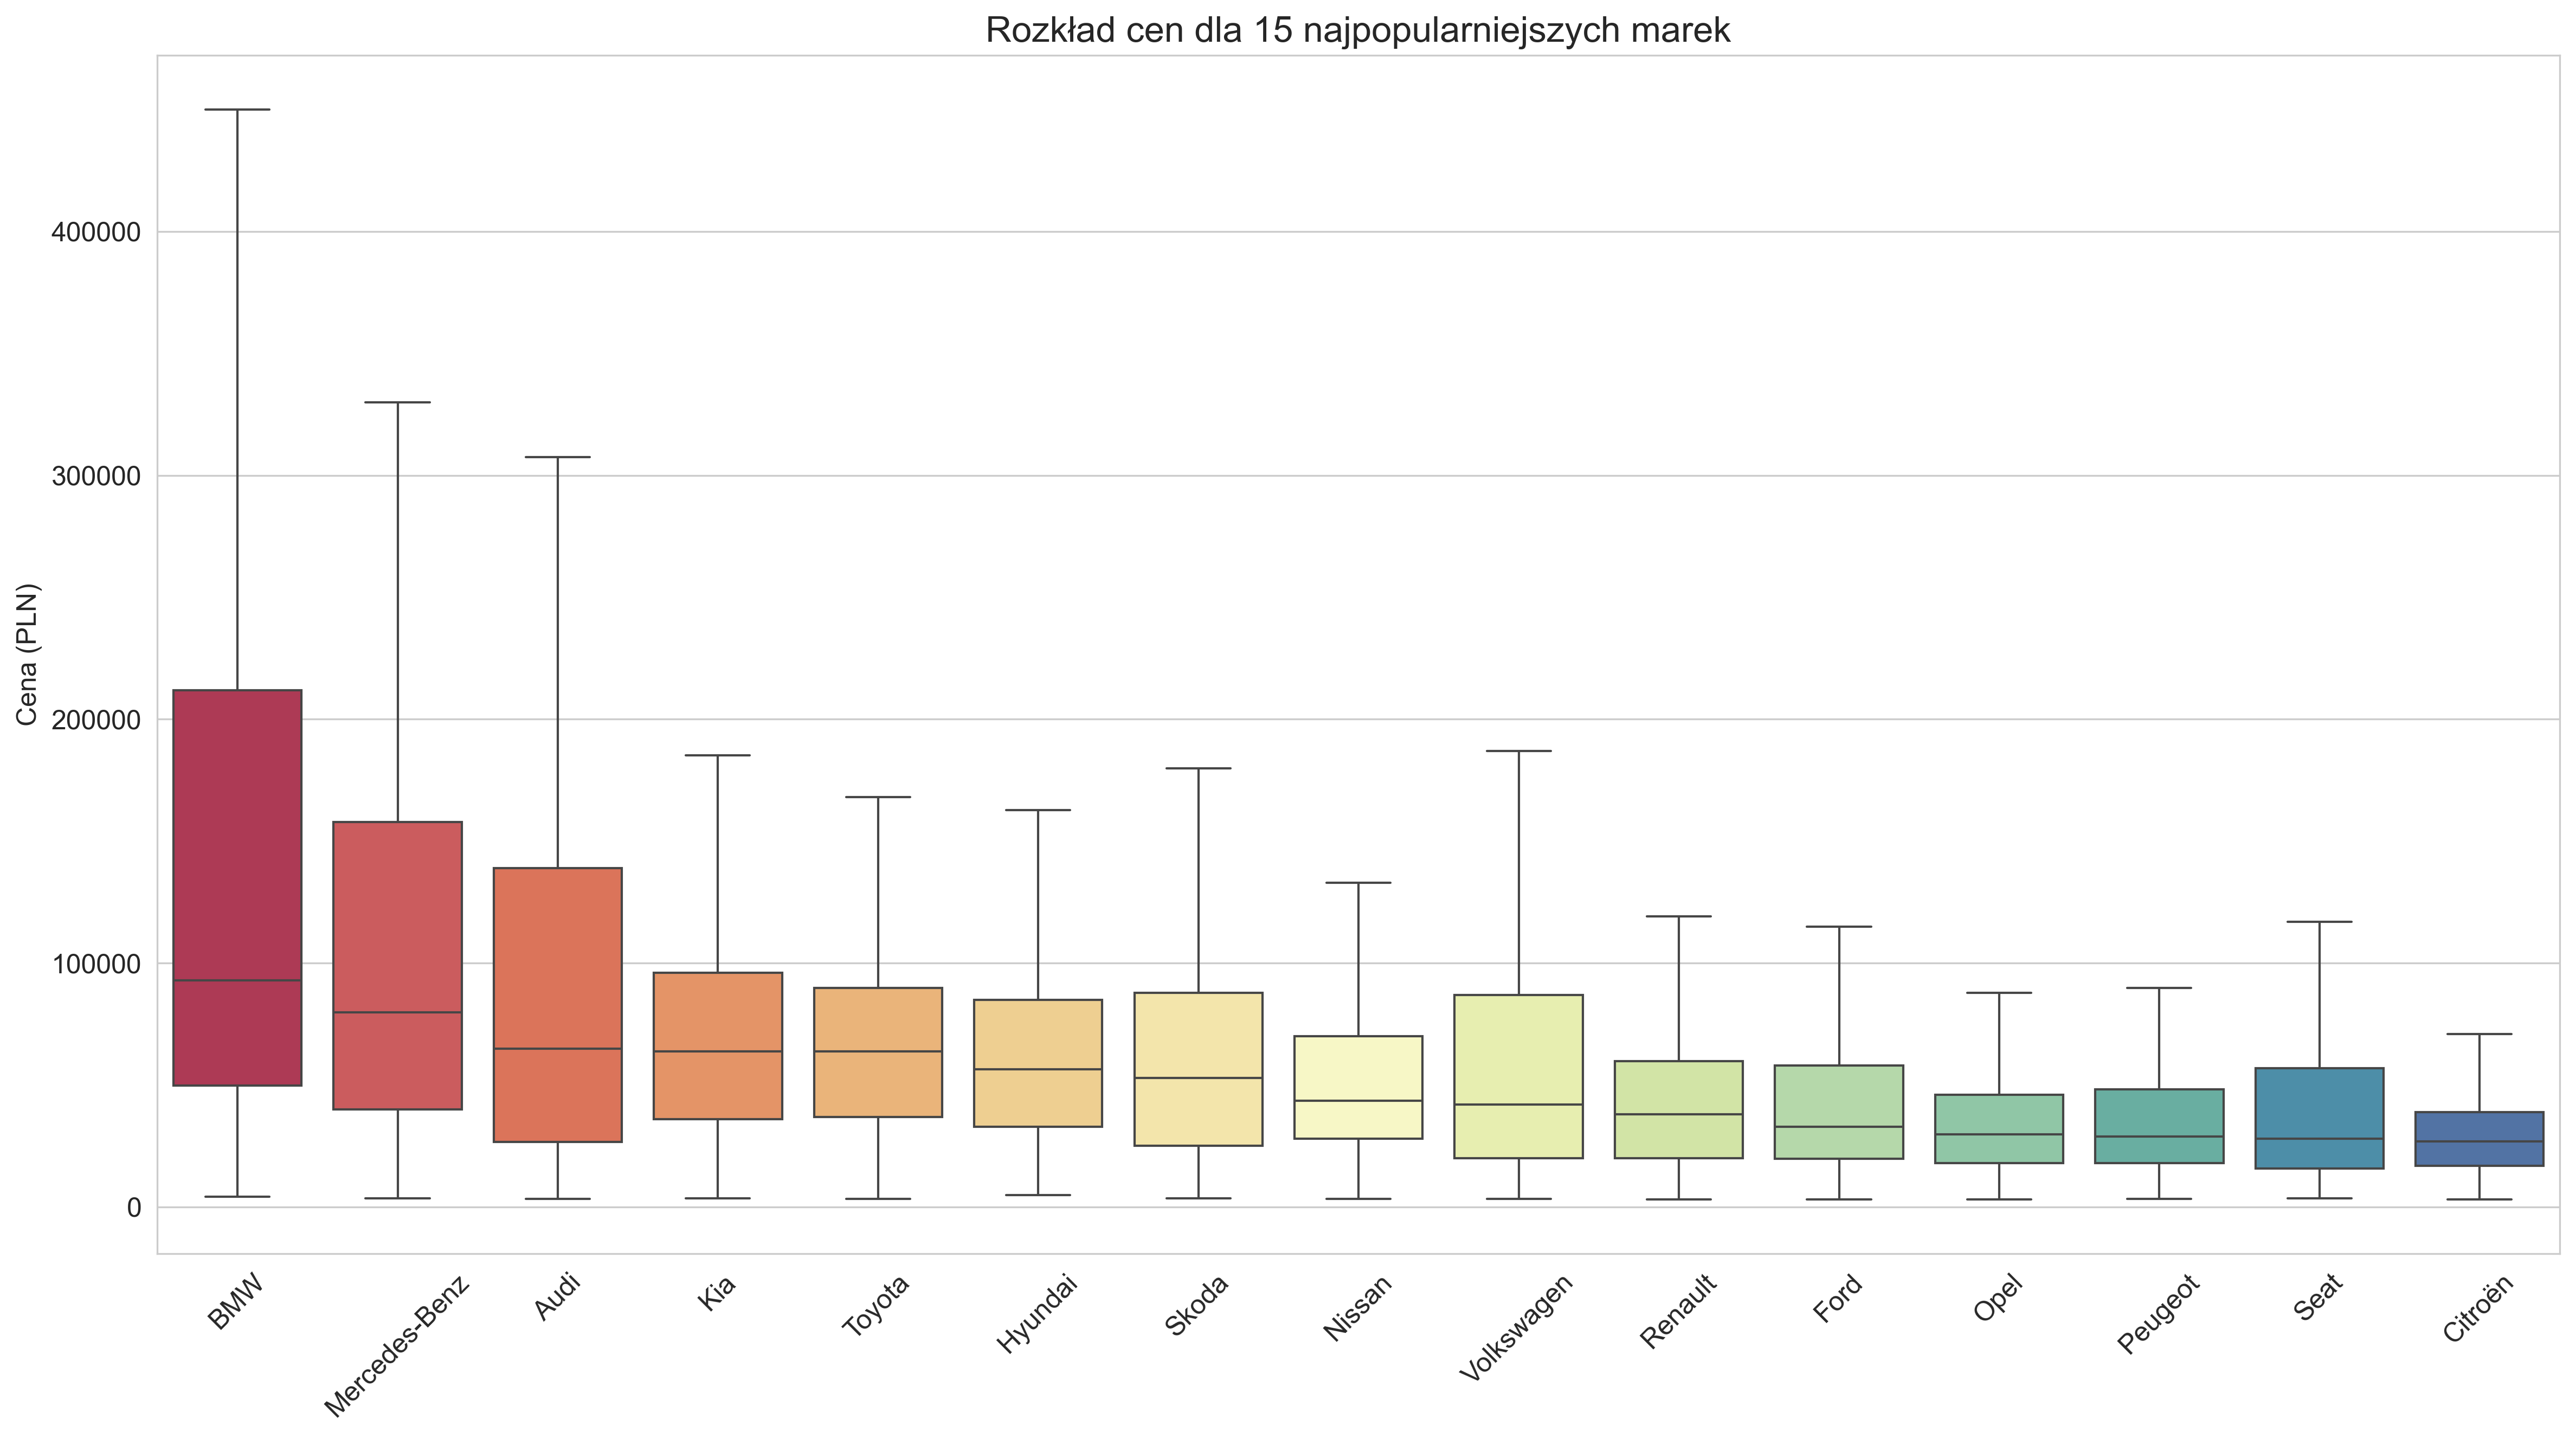

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pymongo import MongoClient
import joblib
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import datetime

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300 # Wysoka rozdzielczość

print("--- GENERATOR WYKRESÓW ---")

# 1. WCZYTANIE DANYCH (Logika zgodna z analiza.py)
try:
    client = MongoClient('mongodb://localhost:27017/')
    db = client['otomoto_project']
    collection = db['raw_listings']
    print("✅ Połączono z MongoDB.")
except:
    print("❌ Błąd połączenia z bazą.")
    exit()

# Pobieramy title do NLP
cursor = collection.find({}, {'_id': 0, 'link': 0, 'scraped_at': 0, 'location_city': 0})
df = pd.DataFrame(list(cursor))

if df.empty:
    print("❌ Brak danych.")
    exit()

# 2. CZYSZCZENIE I FILTROWANIE
df = df.drop_duplicates()
df = df.dropna(subset=['price', 'year', 'mileage_km', 'horsepower_hp', 'brand', 'model', 'engine_capacity_cm3'])

current_year = datetime.datetime.now().year

# Filtry identyczne jak w modelu
df = df[(df['price'] > 3000) & (df['price'] < 3000000)]
df = df[(df['year'] >= 2000) & (df['year'] <= current_year + 1)]
df = df[(df['horsepower_hp'] > 40) & (df['horsepower_hp'] < 800)]
df = df[(df['engine_capacity_cm3'] > 500) & (df['engine_capacity_cm3'] < 8000)]

df = df[df['brand'] != "Inna"]
popular_brands = df['brand'].value_counts().head(30).index.tolist()
df = df[df['brand'].isin(popular_brands)]

# 3. FEATURE ENGINEERING (To co widać na wykresach korelacji)
df['car_age'] = current_year - df['year']
df['km_per_year'] = df['mileage_km'] / (df['car_age'] + 1)
df['hp_per_liter'] = df['horsepower_hp'] / (df['engine_capacity_cm3'] / 1000)

# NLP - Wyciąganie cech do wykresów
def check_keywords(text, keywords):
    if not isinstance(text, str): return 0
    text = text.lower()
    return 1 if any(k in text for k in keywords) else 0

df['is_accident_free'] = df['title'].apply(lambda x: check_keywords(x, ['bezwypadkowy', 'bezwypadkowa', 'salon polska', 'pierwszy właściciel']))
df['is_4x4'] = df['title'].apply(lambda x: check_keywords(x, ['4x4', '4wd', 'awd', 'quattro', 'xdrive', '4matic', 'allgrip']))
df['is_sport_pkg'] = df['title'].apply(lambda x: check_keywords(x, ['m-pakiet', 'm pakiet', 'amg', 's-line', 's line', 'rs', 'gti', 'st line']))

# Kopia do wizualizacji (przed One-Hot)
df_viz = df.copy()

# Przycinamy ekstremalne ceny do wykresów 
df_viz = df_viz[df_viz['price'] < 500000]

print(f"📊 Dane gotowe: {len(df_viz)} rekordów.")

# --- GENEROWANIE WYKRESÓW ---

# WYKRES 1: Feature Importance (Z załadowanego modelu)
print("Generowanie: Feature Importance...")
try:
    model = joblib.load('model_ceny_aut.pkl')
    cols = joblib.load('model_kolumny.pkl')
    
    # Pobieramy ważność i sortujemy
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:20] # Top 20 cech
    
    plt.figure(figsize=(12, 10))
    plt.title("Top 20 Cech wpływających na cenę (wg modelu XGBoost)", fontsize=16, fontweight='bold')
    plt.barh(range(len(indices)), importances[indices], align='center', color='#2ecc71')
    plt.yticks(range(len(indices)), [cols[i] for i in indices])
    plt.xlabel("Waga cechy (Gain)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('wykres_1_feature_importance.png')
    print("-> Zapisano wykres_1.png")
except:
    print("⚠️ Nie znaleziono modelu .pkl, pomijam wykres Feature Importance.")

# WYKRES 2: Macierz Korelacji 
print("Generowanie: Macierz Korelacji...")
plt.figure(figsize=(12, 10))
cols_corr = ['price', 'year', 'mileage_km', 'horsepower_hp', 'engine_capacity_cm3', 'hp_per_liter', 'km_per_year']
corr_matrix = df_viz[cols_corr].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Ukrywamy górną połowę (duplikaty)

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1, square=True)
plt.title("Korelacja zmiennych numerycznych", fontsize=16)
plt.tight_layout()
plt.savefig('wykres_2_korelacja.png')
print("-> Zapisano wykres_2.png")

# WYKRES 3: Wpływ Wyposażenia (4x4 i Sport)
print("Generowanie: Wpływ wyposażenia...")
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 4x4
sns.boxplot(data=df_viz, x='is_4x4', y='price', ax=axes[0], palette="Blues", showfliers=False)
axes[0].set_title("Wpływ Napędu 4x4 na cenę", fontsize=14)
axes[0].set_xticklabels(['Napęd Oś', 'Napęd 4x4'])
axes[0].set_xlabel("")
axes[0].set_ylabel("Cena (PLN)")

# Sport
sns.boxplot(data=df_viz, x='is_sport_pkg', y='price', ax=axes[1], palette="Reds", showfliers=False)
axes[1].set_title("Wpływ Pakietu Sport (AMG/M/S-Line)", fontsize=14)
axes[1].set_xticklabels(['Standard', 'Pakiet Sport'])
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.suptitle("Czy wyposażenie dodatkowe podnosi wartość?", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('wykres_3_wyposazenie.png')
print("-> Zapisano wykres_3.png")

# WYKRES 4: Utrata Wartości (Trend)
print("Generowanie: Krzywa spadku wartości...")
plt.figure(figsize=(14, 8))
# Rysujemy scatter plot z małą przezroczystością
sns.scatterplot(data=df_viz, x='year', y='price', hue='fuel_type', alpha=0.6, palette='viridis')
# Dodajemy linię średnią
df_mean = df_viz.groupby('year')['price'].median().reset_index()
plt.plot(df_mean['year'], df_mean['price'], color='red', linewidth=3, linestyle='--', label='Mediana Rynkowa')

plt.title("Spadek wartości w czasie (z podziałem na paliwo)", fontsize=16)
plt.xlabel("Rok Produkcji")
plt.ylabel("Cena (PLN)")
plt.legend(title="Paliwo")
plt.tight_layout()
plt.savefig('wykres_4_utrata_wartosci.png')
print("-> Zapisano wykres_4.png")

# WYKRES 5: Ranking Marek (Boxplot)
print("Generowanie: Ranking Marek...")
top_15_brands = df_viz['brand'].value_counts().head(15).index
df_top15 = df_viz[df_viz['brand'].isin(top_15_brands)]

# Sortujemy wg mediany ceny
order = df_top15.groupby('brand')['price'].median().sort_values(ascending=False).index

plt.figure(figsize=(16, 9))
sns.boxplot(data=df_top15, x='brand', y='price', order=order, palette="Spectral", showfliers=False)
plt.title("Rozkład cen dla 15 najpopularniejszych marek", fontsize=16)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Cena (PLN)")
plt.tight_layout()
plt.savefig('wykres_5_ranking_marek.png')
print("-> Zapisano wykres_5.png")

print("\n✅ GOTOWE! Wszystkie wykresy wygenerowane.")